<div class="alert alert-danger" role="alert">
<h2> Information </h2><br>

This is a version of the notebook with the solutions to the challenges.
    
Below, you will find workgroup assignments in GREEN font color.
    
</div>


# Reinforcement Learning in bandit tasks and gridworlds

Franz Wurm<br>
<sub>Leiden University<sub><br><br>  
    
This is the code for the practical session in the course "2223-S1 Cognitive Modelling: How to build a brain" [(link to Brightspace)](https://brightspace.universiteitleiden.nl/d2l/home/188529)<br>   
Date: 28.09.2022<br>


**Useful references**
- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

## 1. General information

### Goal of this practical

In this practical, you are going to implement a reinforcement learning agent for a standard decision-making problem. Our agent will be able to learn the value of states and actions in the environment simply by observing their associated rewards and punishments. As discussed in the lecture, this resembles the principles of classical and operant conditioning. It is a efficient way of learning that leads to simple, habitual behavioral patterns. 

Step by step, we will discuss the different necessary components to realize such a reinforcement learning agent.

### Setting up this notebook 

This notebook contains all necessary information for the first practical session.

I recommend to download the file and save it to a separate folder. Optimally, this folder is easily accessible (e.g. on your desktop) or implemented in a preexisting folder structure (e.g. MyBachelor>CogMod>PracticalRL).

I also recommend to work with copies. That means, you should not work on the original file, but rather work on copies. This makes sure, that you do not delete important information and always have a basis to go back to. Additionaly, you could implement version control, meaning you save your work to a new file from time to time (e.g., filename_v1, filename_v2). This makes sure you dont lose too much progress in case your computer shuts down or you forgot to press the save button.

The exercise is constructed to be completed chronologically, i.e. from top to bottom. There will be blocks with text, such as the text that you are currently reading, as well as blocks of code, where you can execute commands and computations.

The whole tutorial is written in Python3.

For working on the excersises of the practical I suggest you use [Google Colab](https://colab.research.google.com/) or [Jupyter-notebook](https://jupyter.org/). While Google Colab is straight foward to use, Jupyter-notebook might require you to install additional software (e.g., [Anaconda](https://anaconda.org/))


In [1]:
# first, let's import some packages that we might need

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## 2. k-armed bandit task

In the [bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit), the agent is faced with a choice between multiple options. Named after slot machines in a casino, our one and two-armed versions in the lecture helped to demonstrate the two core principles that allow the agent to achieve his goal of reward maximzation. 

The first thing we will do is to create a _function_ that generates samples from playing such a bandit. 

The function below samples reward drawn from a uniform distribution based on prespecified reward probabilities. As you can see, the function takes input parameters that dictate the number of trials to sample (<code>n_trials</code>) and the reward probablities (<code>probs</code>). 

The function returns and array with reward samples (<code>reward_samples</code>) and the reward probabilities (<code>reward_probs</code>) that generated it. Please note, that specifying more than one reward probabilities (e.g., <code>[0.1, 0,9]</code>) will sample two independent bandits and return them as a matrix.


In [2]:
def generate_uniform_bandit(n_trials,probs):
    
    #preallocation
    reward_samples = np.empty((len(probs),n_trials))
    reward_probs = np.empty((len(probs),n_trials))
    
    for i in np.arange(len(probs)):
        
        #get samples for each bandit
        reward_samples[i,:] = np.random.binomial(1,probs[i],n_trials)
        reward_probs[i,:] = probs[i]
        
    
    return reward_samples, reward_probs

As discussed in the lecture, the two principles of reinforcement learning are
- the learning rule: updating of expectations based on observations 
- the decision rule: taking actions based on expectations


## 3. Learning rule 

The learning rule should help our agent to build up expectations about its environment.

In this section, we are going to demonstrate why a weighted-average method outperforms a standard average method in changing environments.

### Improving learning... by calculating the average

As a first step, let us have a look at the performance of the averaging method for incremental learning in a stable environment.

We specify the learning rule for incremental averaging in acordance with the formula introduced in the lecture.

$\LARGE V_{t+1} = V_{t} + \frac{1} {t}(R_{t} - V_{t})$,

>where $V$ is the estimated average value,<br>
>and $t$ is the current time step.<br>


In [36]:
n_trials = 1000
prob = [0.7]

reward_samples, reward_probs = generate_uniform_bandit(n_trials,prob)
#a = np.random.binomial(1,0.7,10)


mean_avg = np.empty((1,n_trials+1))
for iT in np.arange(n_trials):
    if iT==0:
        mean_avg[0,0] = 0.5
    mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[0,iT]-mean_avg[0,iT])
    

<div class="alert alert-warning" role="alert">
<h2> Challenge </h2><br>

Show that the incremental average mean indeed converged to the true mean.
    
>HINT: Use the <code>print</code> function and the matplotlib methods, loaded as <code>plt</code>.
</div>

true value: 0.700000
average value: 0.704000
incremental value: 0.704000


Text(0, 0.5, 'estimated reward')

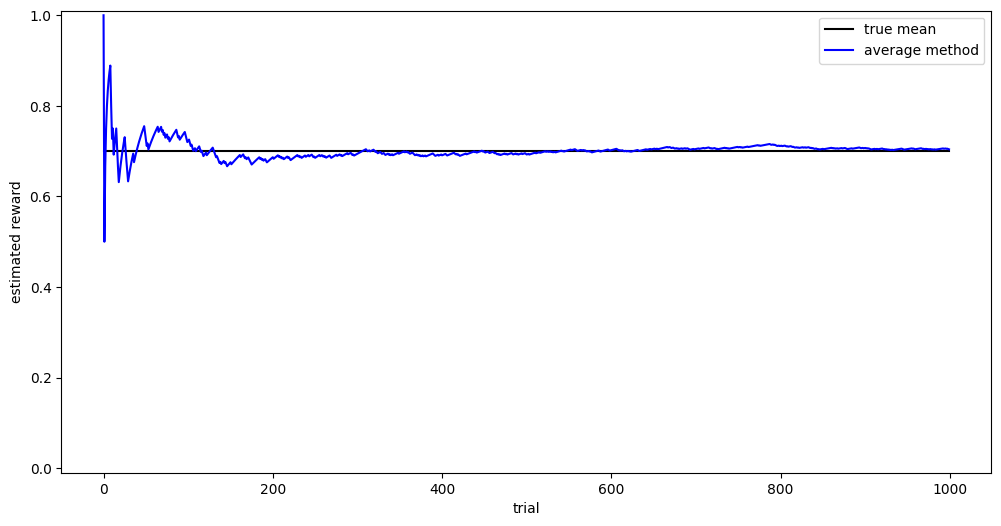

In [37]:
#print(np.arange(n_trials))    
#print(reward_samples)
#print(reward_probs)

print('true value: %f' % np.mean(reward_probs))
print('average value: %f' % np.mean(reward_samples))
print('incremental value: %f' % mean_avg[0,-1])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(np.arange(n_trials),reward_probs[0,:],'-k',label = 'true mean')
ax.plot(np.arange(n_trials),mean_avg[0,1:],'-b',label ='average method')
ax.set_ylim([-0.01,1.01])
plt.legend(loc="upper right")  
ax.set_xlabel('trial')
ax.set_ylabel('estimated reward')

### ...in changing environments

Now that we have seen that the average method of incremental learning does a good job in estimating the average on a step-by-step basis, we are going to extend this example to cover changing environments. 

As shown in the lecture (slide 12), the environment undergoes sudden changes in reward probabilities.

We also implement the weighted-average method as introduced in the lecture.

$\LARGE V_{t+1} = V_{t} + \alpha(R_{t} - V_{t})$,

>where $\alpha$ is the learning rate.<br>

<div class="alert alert-warning" role="alert">
<h2> Challenge </h2><br>

In the code box below, the method vor the average method is already implemented.

Add the weighted average method and plot the results.

</div>

In [34]:
## TODO: Add weighted-average method

n_trials = 1000
reward_prob = [0.7, 0.3, 0.7, 0.3, 0.7, 0.3]
#reward_prob = [1, 0, 1, 0]
lr = 0.01 #fixed learning rate
#lr = 1/(n_trials/10) #fixed learning rate that scales with the horizon of the task

reward_samples, reward_probs = generate_uniform_bandit(n_trials,reward_prob)
#print(reward_samples)

# flattening a m-by-n matrix into a 1-by-m*n vector
reward_samples = np.asarray(reward_samples)
reward_samples = reward_samples.flatten()
reward_probs = np.asarray(reward_probs)
reward_probs = reward_probs.flatten()
# fyi, this problem could also be solved by multiple loops

mean_avg = np.empty((1,len(reward_prob)*n_trials+1))
mean_wgt = np.empty((1,len(reward_prob)*n_trials+1))
for iT in np.arange(len(reward_prob)*n_trials):    
    if iT==0: #initialize at time point 0
        mean_avg[0,0] = 0.5
        mean_wgt[0,0] = 0.5   
    #update estimated values    
    mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[iT]-mean_avg[0,iT])
    mean_wgt[0,iT+1] = mean_wgt[0,iT] + lr*(reward_samples[iT]-mean_wgt[0,iT])

Text(0, 0.5, 'estimated reward')

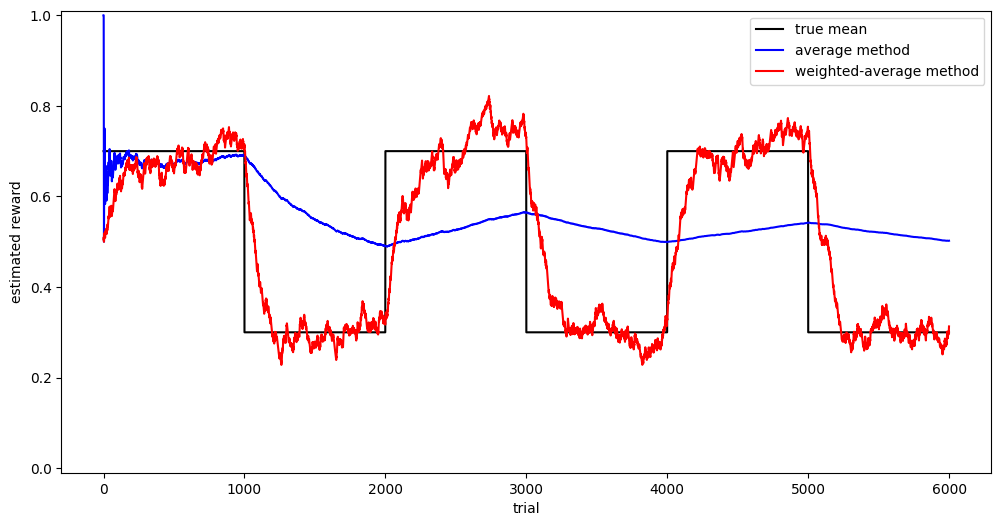

In [35]:
## TODO: Plotting

#print(reward_samples)
#print(mean_avg[0,1:])
#print(mean_wgt[0,1:])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(np.arange(len(reward_prob)*n_trials),reward_probs,'-k',label = 'true mean')
ax.plot(np.arange(len(reward_prob)*n_trials),mean_avg[0,1:],'-b',label = 'average method')
ax.plot(np.arange(len(reward_prob)*n_trials),mean_wgt[0,1:],'-r',label = 'weighted-average method')
ax.set_ylim([-0.01,1.01])
plt.legend(loc="upper right")  
ax.set_xlabel('trial')
ax.set_ylabel('estimated reward')

## 3. Decision rule

So far, we have only dealt with prediction problems. However, the most powerful application of reinforcement learning lies in solving control problems. 

The decision rule (or policy) defines the agent's way of behaving at a given time or state. This is and extension of the previous prediction problem, as we now also consider actions given each state. Put differently, the policy is a mapping between states and actions and it corresponds to what psychologists sometimes call a stimulus-response association.


### Improving decision making... by exploration

In order to replicate the results for the improvement of decision-making as shown in the lecture (slide 15), we first need to set up a new bandit function.

This new bandit function again takes two input parameters and give two output parameter. In contrast to the previous bandit, the current bandit will draw its reward from a normal distribution. So we will not specify reward probabilities but rather <code>reward_means</code> as the second argument.


<div class="alert alert-warning" role="alert">
<h2> Challenge </h2><br>

Add a function to the routine below that does sample rewards from a normal distribution with a mean of <code>means</code> and a standard deviation of <code>1</code>.

</div>

In [14]:
def generate_normal_bandit(n_trials,means):
    
    # set the same random seed so we replicate the same random values
    #np.random.seed(2)
    
    #preallocation
    reward_samples = np.empty((len(means),n_trials))
    reward_means = np.empty((len(means),n_trials))
    
    for i in np.arange(len(means)):
    
        #get samples for each bandit
        reward_samples[i,:] = np.random.normal(means[i],1,n_trials)
        reward_means[i,:] = means[i]
        
    
    return reward_samples, reward_means

#a,b = generate_normal_bandit(10,[-1,0,1])
#print(a)

During the lecture, we introduced a few different decision rules and of course the list in not exhaustive. Below you find the most commonly used methods:
- random method
- greedy method
- e-greedy method
- softmax method

Let's first implement the different methods for action selection.

In [19]:
def action_random(values):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    action = np.random.choice(actions)
    
    return action

def action_greedy(values):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    ties = np.array(values[:,0] == np.max(values[:,0]))
    action = np.random.choice(actions[ties]) 
    
    return action

def action_epsilon(values,epsilon):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    if (np.random.random() < epsilon):
        action = action_random(values)
    else:
        action = action_greedy(values)
    
    return action


Let's make a few assumptions for our simulation first.

In [ ]:
n_agents = 1000
n_trials = 1000
n_bandits = 10
#reward_means = [-1.5,-1,-0.5,0,0.5,1,1.5]

#### Greedy agents

In the following code block I have set up a number of greedy agents.

In accordance with the lecture, both the average for the rewards (<code>rewards_greedy</code>) and the percentage of optimal decisions (<code>optimum_greedy</code>) will be saved for plotting.

Please note, that we implement the _average methode_ as the learning rule. As this is a stable environment, the properties of the average method guarantee that our estimates converge to the optimum/true value (at least with an appropriate action selection method...).

In [20]:
## greedy action selection

rewards_greedy = np.empty((n_agents,n_trials))
optimum_greedy = np.empty((n_agents,n_trials))
for iA in np.arange(n_agents):

    reward_means = np.random.normal(0,1,(n_bandits,1))
    optimal_action = np.argmax(reward_means)
    reward_samples, reward_probs = generate_normal_bandit(n_trials,reward_means)

    #initialize the estimated values for each bandit
    values = np.zeros((len(reward_means),1))
    action_count = np.zeros((len(reward_means),1))
    
    for iT in np.arange(n_trials):    
        #chose action
        action = action_greedy(values)
        action_count[action,0] =  action_count[action,0]+1
        #calculate prediction error
        PE = reward_samples[action,iT]-values[action,0]
        #update value
        values[action,0] = values[action,0] + (1/action_count[action,0])*PE
        #store reward & optimal decision
        rewards_greedy[iA,iT] = reward_samples[action,iT]
        if action == optimal_action:
            optimum_greedy[iA,iT] = 1
        else:
            optimum_greedy[iA,iT] = 0


#### $\epsilon$-greedy action selection

Basically, the $\epsilon$-greedy agent is identical to the greedy agent with the the minor detail that on 100*$\epsilon$% of the trials a random action will be chosen.

You find the code for $\epsilon$-greedy actions selection already above.

In [24]:
epsilon = 0.1

rewards_egreedy = np.empty((n_agents,n_trials))
optimum_egreedy = np.empty((n_agents,n_trials))
for iA in np.arange(n_agents): 

    reward_means = np.random.normal(0,1,(n_bandits,1))
    optimal_action = np.argmax(reward_means)
    reward_samples, reward_probs = generate_normal_bandit(n_trials,reward_means)

    #initialize the estimated values for each bandit
    values = np.zeros((len(reward_means),1))
    action_count = np.zeros((len(reward_means),1))
    
    for iT in np.arange(n_trials):    
        #chose action
        action = action_epsilon(values,epsilon)
        action_count[action,0] =  action_count[action,0]+1
        #calculate prediction error
        PE = reward_samples[action,iT]-values[action,0]
        #update value
        values[action,0] = values[action,0] + (1/action_count[action,0])*PE
        #store reward
        rewards_egreedy[iA,iT] = reward_samples[action,iT]
        if action == optimal_action:
            optimum_egreedy[iA,iT] = 1
        else:
            optimum_egreedy[iA,iT] = 0     


Text(0, 0.5, '% optimal choice')

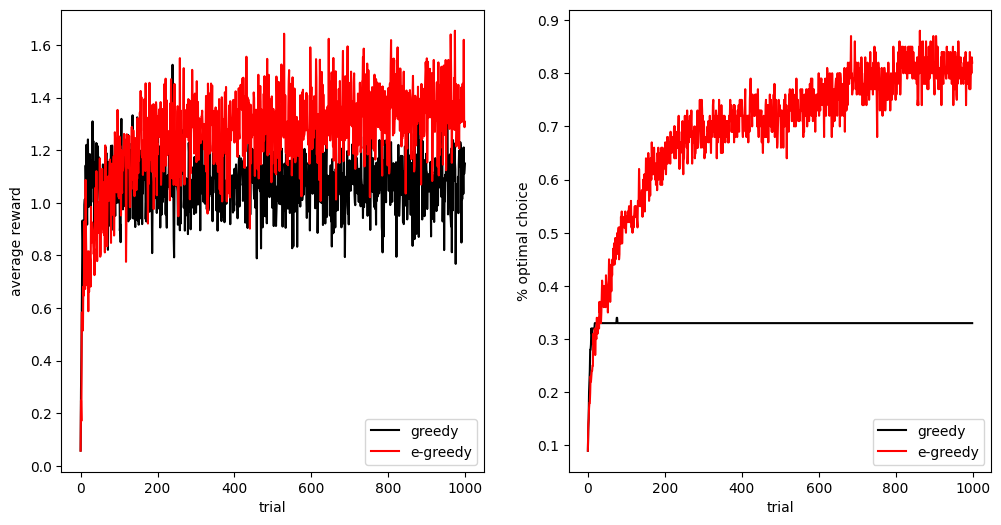

In [31]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.plot(np.arange(n_trials),np.mean(rewards_greedy,0),'-k',label='greedy')
ax.plot(np.arange(n_trials),np.mean(rewards_egreedy,0),'-r',label='e-greedy')
plt.legend(loc="lower right") 
ax.set_xlabel('trial')
ax.set_ylabel('average reward')
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(n_trials),np.mean(optimum_greedy,0),'-k',label='greedy')
ax2.plot(np.arange(n_trials),np.mean(optimum_egreedy,0),'-r',label='e-greedy')
plt.legend(loc="lower right")   
ax2.set_xlabel('trial')
ax2.set_ylabel('% optimal choice')

<div class="alert alert-warning" role="alert">
<h2> Challenge </h2><br>

It seems that something is wrong with the code. Can you figure out why the results of our code do not replicate the simulations results of Sutton & Barto? In silico, the $\epsilon$-greedy method should outperform the greedy method for this environment. However it does not.
    
>HINT: Have a look at the updating function.
</div>

### Softmax action selection

Let's have a closer look at the softmax rule, as this is maybe the most widely used decision rule in the neuroscientific literature.

$\LARGE p(a)= \frac{e ^{(\beta * Q(a))}} {\sum \limits _{a'} e ^{(\beta * Q(a'))}}$ 

In [26]:
def action_softm(values,beta):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    prob = np.exp(beta*values)/np.sum(np.exp(beta*values))
    action = np.random.choice(actions,size = 1, p = prob) 
    
    return action, prob

<div class="alert alert-warning" role="alert">
<h2> Challenge </h2><br>

The central part of the softmax algorithm is missing.
    
>HINT: Use prespecified numpy methods.
</div>

If we want to put this softmax function to use, we can make a few hypothetical assumptions for our bandit task.

For example, let's assume our agent has played the slot machine twice, each arm one time. The left arm lead to a reward (1), whereas the right arm did not result in a reward (0). We can translate this experience into simplified expectations (values) for the next game.

In [27]:
dummy_values = np.array([1,0])
beta = 1

action,prob = action_softm(dummy_values,beta)

print('Chosen action: %d' % (action))
print('Action probablities: %s' % (np.array2string(prob)))

Chosen action: 1
Action probablities: [0.73105858 0.26894142]


We can see, that the dummy expectations translate into action probabilites in a straightforward way. The highest value has the highest action probability.

<div class="alert alert-warning" role="alert">
<h2> Idea </h2><br>
Play around with the beta value and observe the changes!
    
</div>

As already discussed in the lecture, the beta (or 'inverse temperature') affects the so-called [gain](https://en.wikipedia.org/wiki/Gain_(electronics)). The higher the gain, the more pronounced the differences in action values get translated into action probabilities.

We can plot this in a systematic way.

<div class="alert alert-warning" role="alert">
<h2> Challenge </h2><br>
Setup a plot similar to slide 17 in the lecture.<br>
- x-axis: differences in values<br>
- y-axis: action probablity for option 1<br>
    
</div>


In [28]:
betas = [0,1,2,5,10]
x = np.arange(-2,2,0.1)

all_probs = np.empty((len(betas),len(x)))

for i in np.arange(len(betas)):    
    for j in np.arange(len(x)):
        values = dummy_values*x[j]
        action,prob = action_softm(values,betas[i]) 
        all_probs[i,j] = prob[0]
        

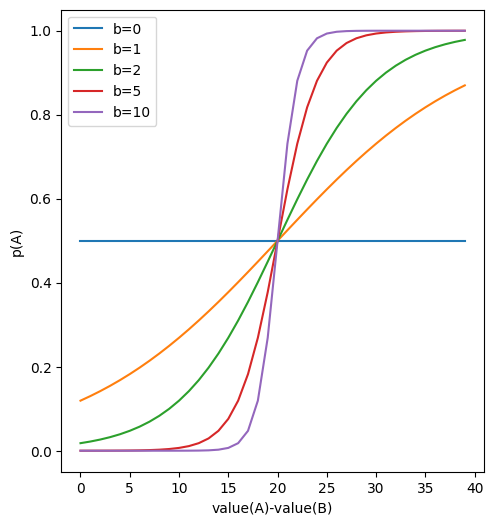

In [30]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.set_prop_cycle
ax.set_xlabel('value(A)-value(B)')
ax.set_ylabel('p(A)')

for i in np.arange(len(betas)):
    ax.plot(np.arange(len(x)),all_probs[i,:],'-',label='b='+str(betas[i]))
plt.legend(loc="upper left")    
    
    
    #print(values)

#print(x)

<div class="alert alert-success" role="alert">
<h2> Assignment 1 (40 points) </h2><br>
Besides the bandits encountered above, we can construct a wide variety of different versions.
    
For example, the type of reward distribution can be varied. We have already encountered _probabilistic rewards_ in the <code>generate_uniform_bandit</code>. For this bandit, reward distributions indicated the reward probablity associated with each action. We have also already encountered _determinstic rewards_ in the <code>generate_normal_bandit</code>. Contrary to the probablistic rewards, determinstic rewards do not include binomial noise, but instead the action pay off rewards that are directly proportional to its value in the reward distribution.  
    
Moreover, we can make a distinction betwee _fixed_ and _walking_ reward distributions. So far, we have only encountered fixed rewards distributions. Rewards were always drawn from a stable environment and did not change over time. For walking rewards distributions, noise is added to the defining parameters of the distribution. For example, on every new trial of our <code>generate_uniform_bandit</code>, the new reward probablity could be set to the old rewards probability plus some normal noise with mean 0 and standard deviation 0.05. Please note, that this makes it necessary to define bounds, as rewards probabilities (e.g., binomial) need to be set between 0 and 1, or determinstic rewards (e.g., normal) should not wander off too much but rather stay between 0 and 100.
    
    
> Set up the 4 possible bandits with the following properties<br>
> 1. probabilistic rewards with fixed reward probabilities (as implemented already in <code>generate_uniform_bandit</code>)
> 2. probabilistic rewards with walking reward probabilities
> 3. deterministic rewards with fixed reward probabilities (bound between 0 and 1)
> 4. deterministic rewards with walking reward probabilities (bound between 0 and 1)

> Visualize the bandits. Therefore, use one-armed variants. Plot their reward probabilites, obtained rewards etc.
    
> Plot how the performance of our RL agents differs between these bandits. For the bandits, use two-armed variants. For the agent, fix the learning rate (alpha) to 0.1 and the softmax inverse temperature (beta) to 2.
    
    
</div>

<div class="alert alert-success" role="alert">
<h2> Assignment 2 (30 points) </h2><br>

Environmental change is a crucial aspect that any learning agents has to take into account. We have already seen, how different learning rules (average vs. weighted-average) can be (mal)adaptive, dependent on the environment. Now, we are going to have a closer look into this issue and investigate how the speed of environmental change influences performance of our bandit.     
    
> Set up a bandit with determinstic rewards and walking reward probabilities (see bandit option 4 in assignment 1) 
    
> Before coding, come up with hypotheses. Would you want your learning rate (alpha) to be high or low in a rapidly changing environment? Would you want your inverse temperature (beta) to be higher or lower in rapidly changing environments?
    
> Show, how the parameters of our agent is traded-off with different speeds of environmental volatility. Could you verify your intuitions as stated in the hypotheses?

    
</div>

<div class="alert alert-success" role="alert">
<h2> Assignment 3 (30 points) </h2><br>

So far, we have encountered two measures of performance: 
- Overall or average reward collected by the agent
- proportion of optimal (=greedy) choices
    
There is a another way to look at performance: How well do our expectations of the environment match with the true value of the environment? Put differently, how well do our Q-values track the reward probabilities that generate rewards? The idea is simple: The better our estimate about the true values, the better our decision making will be.
    
> Plot the Q values together with the reward probabilities and compare the performance of the same RL agents for probabilistic and determinstic rewards in a walkig/changing environment.      

A simple metric that you could utilize to quantify performance is the correlation coefficient. High correlation means that Qvalues and true probabilities are aligned, with r=1 indicating a perfect match. Low correlation means that Qvalues and true probabilities are not aligned, with r=0 indicating no connection at all.
    
> Compare the performance of different agents. Can you manually fine-tune the agent's parameters to optimize correlation?    
    
    
(Please note that averaging correlation coefficients, e.g. between blocks or agents, is a bit tricky. Use Fisher's z transformation, average, and then transform back, to obtain meaningful results. Alternatively you could also estimate one correlation coefficient for ALL data at once.)

 
</div>

[fisher's z](https://en.wikipedia.org/wiki/Fisher_transformation)<br>



## additional material

For inspiration and more material on reinforcement learning and bandits, see

[link to mf/mb RL](https://github.com/ClaireSmid/Model-free_Model-based_Workshop)<br>

## The grid world problem

*Grid worlds* are simplified respresentations of the environment, that are often used for navigation simulation. As is implied by the name, grid worlds break down the environment into a grid, similar to a chess board. For the scope of this course we are going to stick with a very basic 4x4 gridworld.

Before we dive further into the code, a bit more background information on gridworlds. 

Gridworlds are so-called [Markov Decision Processes](https://en.wikipedia.org/wiki/Markov_decision_process). In contrast to the previous bandit task, gridworlds usually are multi-step problems, meaning that actions executed in one state cannot only result in reward, but also affect the upcoming state. This necessitates the agent to not only consider the immediate reward but also the expected cumulative reward. 

```
  ____    ____     ____   ____
  ____    ____     ____   ____

|| s00  |  s01  |  s02 | s03 ||
  ____    ____     ____   ____
    
|| s04  |  s05  |  s06 | s07 ||
  ____    ____     ____   ____
  
|| s08  |  s09  |  s10 | s11 ||
  ____    ____     ____   ____
   
|| s12  |  s13  |  s14 | s15 ||
  ____    ____     ____   ____
  ____    ____     ____   ____
```

Our agent always starts in the same start state (s_0, top left of board). From there, it will take *steps*, that gradually move him across the board. Movement is restricted to the cardinal directions (up, down, right, left). Reward is located in the terminal state (s_15, bottom right of board). Upon arrival at the site of reward, the agent receives the reward (associated with a positive value) and will be returned to the initial state, so the whole procedure can start again. The (time)steps between start and terminal state are regarded as a *run* (or *episode*). Start state, reward and terminal state do NOT change between runs. Thus, our gridworld environment is stable. Also, because each action transitions to a new state with 100% chance, the environment is also considered deterministic.

For this grid world example, we will implement the Q learning rule, which is defined as

$\LARGE Q_{new}(s,a) = Q_{old}(s,a) + \alpha * (R + \gamma max_{a} Q_{old}(s',a) - Q_{old}(s,a))$,

    where $\alpha$ is the learning rate,
    $\gamma$ is the discounting factor,
    and s' is the next state

Below, we define the most basic details for our gridworld.

In [40]:
nTrial = 50 #specify how many times you want to run the q-learning function
nAgent = 1

method = 'egreedy' #options: greedy | egreedy | softmax

alpha = 0.1 #learning rate
beta = 1 #inverse temperature
gamma = 1 # discounting factor
epsilon = 0.1 #parameter for ε-greedy action selection

actions = np.array(['up', 'left', 'down', 'right'])

s_0 = 0 #start state
s_terminal = 15 #final state (goal)

envsize = 4 #size of the environment (n x n)
iZ = 0
states= np.empty([envsize,envsize],dtype=float)
for iY in range(envsize):
    for iX in range(envsize):
        states[iY][iX] = iZ
        iZ +=1
#print('states')
#print(states)        

movecounter = np.empty([nTrial,nAgent] )

### Helper function

Some computational steps have to be performed multiple times.
Here we define those function so we can call them later on in the script.

In [46]:
# this is not an essential package, but it helps us to save variables for visualisation
from copy import deepcopy

In [47]:
def move1step(instate,action):
    
    coords = list(np.where(states == instate))
    
    if (action == 'up'):
        coords[0] -= 1
    if (action == 'down'):
        coords[0] += 1
    if (action == 'left'):
        coords[1] -= 1
    if (action == 'right'):
        coords[1] += 1
        
    if (coords[0] < 0):
        coords[0] = 0
    if (coords[1] < 0):
        coords[1] = 0 
    if (coords[0] >= envsize):
        coords[0] = envsize-1    
    if (coords[1] >= envsize):
        coords[1] = envsize-1
        
    outstate = states[coords[0],coords[1]]   
    return(outstate)  

def getReward(state1,state2):
    if (state2 == s_terminal):
        reward = 10 #final reward at the end of the run
    else:
        reward = 0 #intermediate reward (after each action) 
    if (state1 == state2):
        reward = 0 #reward for running into a wall?
    return reward    

Now that we have defined the most crucial parts for our grid world, we can put everything together.

For convenience, I have already added multiple agents, as this will allow us to draw more precise conclusions from the simulation data.

For the agent's parameters I have implemented very basic values. You can have a look how changing those parameters affects the performance in the grid world.

In [52]:
print('Agent')
for iA in range(nAgent):
    
    print(iA, end=' ')
    Q = np.zeros([len(actions),envsize,envsize] )

    #print('initial Q matrix:\n' + str(Q) + '\n')
    Q0 = deepcopy(Q)

    for iT in range(nTrial): # loop for the different runs
        #if (iT % 100) == 0:
            #print(iT)
        state = s_0
        moves = 0
        while (state != s_terminal): # loop within one run
        
            coord0 = np.where(states == state)

            qvals = Q[:,coord0[0],coord0[1]]
              
            # select action using choice rules
            if (method == 'softmax'):
                pvals = np.exp(beta*qvals)/np.sum(np.exp(beta*qvals))
                action = np.random.choice(actions,size = 1, p = pvals.flatten())            
            elif (method == 'greedy'):
                choices = np.array(qvals == np.max(qvals))
                action = np.random.choice(actions[choices.flatten()])            
            elif (method == 'egreedy'):
                if (np.random.random() < epsilon):
                    action = np.random.choice(actions, size = 1)
                else:
                    choices = np.array(qvals == np.max(qvals))
                    action = np.random.choice(actions[choices.flatten()])
            else:
                action = np.random.choice(actions)
        
            # interact with environment
            next_state = move1step(state,action)
            #print('next state: '+str(next_state))
            reward = getReward(state,next_state)
        
            actionidx = (action==actions)
            coord1 = np.where(states == next_state) 
        
            # update expectations using learing rules
            Q[actionidx,coord0[0],coord0[1]] = Q[actionidx,coord0[0],coord0[1]] + alpha * (reward + gamma * np.max(Q[:,coord1[0],coord1[1]]) - Q[actionidx,coord0[0],coord0[1]])
        
            if ((iT == 0) and (next_state == s_terminal)):
                #print('Q matrix before first successful run:\n' + str(Q) + '\n')
                Q1 = deepcopy(Q)
        
            # update variables
            state = next_state
            moves += 1
        
        #end of while loop
        movecounter[iT,iA] = moves
    #end of trial for loop
    #print('final Q matrix:\n' + str(Q) + '\n')
    Q2 = deepcopy(Q)
#end of agent for loop
#print('\n\nFinal Q(s,a) for agent '+str(iA))
#print(Q)

Agent
0 

In order to better understand the agents' behavior in the gridworld we can again make use of the `print()` and `plot()` function.

<div class="alert alert-warning" role="alert">
<h2> Questions </h2><br>
Before we continue, think about the performance of our agent. Do you have any hypothesis about this? What would you expect from a RL agent? How should his behavior change?
    
</div>

In the following sections we will try to answer those questions.

### Plotting performance

**Question:** What is our hypothesis for the performance of our agent?

**Answer:** Performance for learning agents should improve over time. Therefore we should expect to find improvements in performance for our grid world agent. Performance can be measured in multiple different ways. For our grid world example, we could define performance as is already plotted below: the number of steps it takes the agents to get from start state to terminal state. While the agent is aimlessly roaming the gridworld in the beginning, it quickly picks up the optimal path to the goal.

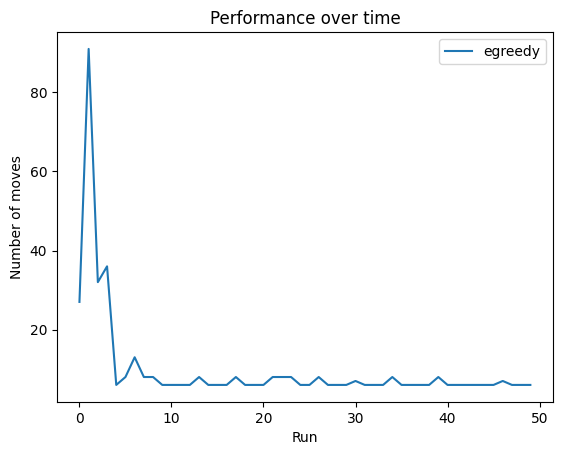

In [53]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.

xdata = range(nTrial)
ydata = np.mean(movecounter,axis=1)

ax.plot(xdata, ydata, label = method)  # Plot some data on the axes.

ax.set_title('Performance over time')
ax.set_xlabel('Run')
ax.set_ylabel('Number of moves')
ax.legend()

### Plotting values and policies

We can also visualize the state and action values of our gridworld. 

In [54]:
Qmat0 = np.max(Q0,axis=0)
Qmat1 = np.max(Q1,axis=0)
Qmat2 = np.max(Q2,axis=0)

print(Qmat0)
print(Qmat1)
print(Qmat2)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
[[3.69723707e+00 6.67910800e-03 4.62342661e-01 0.00000000e+00]
 [5.56907816e+00 7.40928846e+00 8.79672340e+00 9.63128631e+00]
 [0.00000000e+00 4.68559000e-02 2.70472423e+00 9.94846225e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


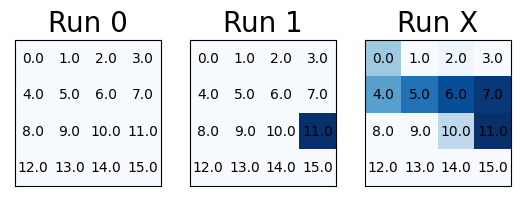

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

layout = [['s0', 's5/6'], ['s1', 's4'], ['s2', 's3']]

min_val, max_val = -1, 10

for i in range(envsize):
    for j in range(envsize):
        ax1.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax2.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax3.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
ax1.matshow(Qmat0, cmap=plt.cm.Blues)  
ax2.matshow(Qmat1, cmap=plt.cm.Blues)
ax3.matshow(Qmat2, cmap=plt.cm.Blues)

ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax3.axes.xaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)

ax1.title.set_text('Run 0')
ax1.title.set_size(20)
ax2.title.set_text('Run 1')
ax2.title.set_size(20)
ax3.title.set_text('Run X')
ax3.title.set_size(20)
